# MNIST

This notebook contains our experiements comparing forward gradient and backpropagation with neural networks and Convolutional nets for the MNIST dataset

#### Setup

In [ ]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.8 MB 48 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

{'restart': True, 'status': 'ok'}

In [ ]:
!git clone https://github.com/benjaminrike1/forward_gradient

Cloning into 'forward_gradient'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 112 (delta 54), reused 76 (delta 29), pack-reused 0
Receiving objects: 100% (112/112), 1.94 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
cd forward_gradient

/content/forward_gradient


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD, ForwardAdam
from models import Net, ConvNet

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## MNIST

Importing the data from torchvision.

In [ ]:
# transforming images to tensors
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


mnist_train = torchvision.datasets.MNIST(
    '/tmp/data',
    train=True, 
    download=True, 
    transform=transform
)

# splitting into training and validation set
train, val = torch.utils.data.random_split(mnist_train, [50000, 10000])

train_data_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=64, 
                                          shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val, 
                                          batch_size=64, 
                                          shuffle=True)

# loading test set
mnist_test = torchvision.datasets.MNIST(
    '/tmp/data',
    train=False, 
    download=True, 
    transform=transform
)
test_data_loader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=64,
                                              shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



# Neural Network

We first use a vanilla feedforward network for the optimization. The net can be found in `models.py`

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-4, -3, 4)
decays = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.251
Validation loss for lr = 0.000100, decay = 0.000010: 2.242
Validation loss for lr = 0.000100, decay = 0.000000: 2.249
Validation loss for lr = 0.000215, decay = 0.000001: 2.141
Validation loss for lr = 0.000215, decay = 0.000010: 2.141
Validation loss for lr = 0.000215, decay = 0.000000: 2.140
Validation loss for lr = 0.000464, decay = 0.000001: 11.586
Validation loss for lr = 0.000464, decay = 0.000010: 1.126
Validation loss for lr = 0.000464, decay = 0.000000: 1.562
Validation loss for lr = 0.001000, decay = 0.000001: 14.514
Validation loss for lr = 0.001000, decay = 0.000010: 14.127
Validation loss for lr = 0.001000, decay = 0.000000: 13.713


Searching for best learning rate and learning rate decay for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 4)
decays = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = Net().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.001000, decay = 0.000001: 0.742
Validation loss for lr = 0.001000, decay = 0.000010: 0.737
Validation loss for lr = 0.001000, decay = 0.000000: 0.745
Validation loss for lr = 0.004642, decay = 0.000001: 0.310
Validation loss for lr = 0.004642, decay = 0.000010: 0.312
Validation loss for lr = 0.004642, decay = 0.000000: 0.304
Validation loss for lr = 0.021544, decay = 0.000001: 0.150
Validation loss for lr = 0.021544, decay = 0.000010: 0.148
Validation loss for lr = 0.021544, decay = 0.000000: 0.149
Validation loss for lr = 0.100000, decay = 0.000001: 0.071
Validation loss for lr = 0.100000, decay = 0.000010: 0.079
Validation loss for lr = 0.100000, decay = 0.000000: 0.070


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000464
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay)

# running the code for e epochs
losses_fwd = []
norms = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(np.abs(norm.item()))
    except:
      norms.append(np.abs(norm))
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.276754379272461
Test loss in epoch 2: 2.229856491088867
Test loss in epoch 3: 2.245063066482544
Test loss in epoch 4: 2.1505117416381836
Test loss in epoch 5: 2.007540225982666
Test loss in epoch 6: 1.9714754819869995
Test loss in epoch 7: 1.8052902221679688
Test loss in epoch 8: 1.4845551252365112
Test loss in epoch 9: 1.513105869293213
Test loss in epoch 10: 0.7407682538032532
Test loss in epoch 11: 1.9370222091674805
Test loss in epoch 12: 12.953187942504883
Test loss in epoch 13: 13.771442413330078
Test loss in epoch 14: 14.945985794067383
Test loss in epoch 15: 10.55512809753418
Test loss in epoch 16: 12.953187942504883
Test loss in epoch 17: 12.953187942504883
Test loss in epoch 18: 15.942384719848633
Test loss in epoch 19: 12.953187942504883
Test loss in epoch 20: 14.945985794067383
Test loss in epoch 21: 10.960390090942383
Test loss in epoch 22: 10.960390090942383
Test loss in epoch 23: 14.945985794067383
Test loss in epoch 24: 13.949586868286133
Test lo

Text(0.5, 1.0, 'Jacobian vector norm per iteration')

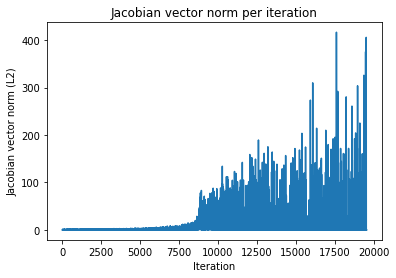

In [ ]:
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("Jacobian vector norm (L2)")
plt.title("Jacobian vector norm per iteration")

In [ ]:
print(np.max(norms[:10000])); print(np.max(norms)); print(np.max(norms[:11000]))
print(np.mean(norms[:10000]))
print(np.std(norms[:10000]))

87.86993408203125
416.6250915527344
134.16180419921875
3.340167948278336
7.877840072580223


As can be seen, we deal with exploding gradients. To mitigate this, we utilize gradient clipping. Specifically, we impose that the norm of the Jacobian vector product must be less than 1.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000464
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.276
Test loss in epoch 2: 2.231
Test loss in epoch 3: 2.251
Test loss in epoch 4: 2.168
Test loss in epoch 5: 2.067
Test loss in epoch 6: 2.077
Test loss in epoch 7: 1.972
Test loss in epoch 8: 1.864
Test loss in epoch 9: 1.827
Test loss in epoch 10: 1.727
Test loss in epoch 11: 1.633
Test loss in epoch 12: 1.595
Test loss in epoch 13: 1.352
Test loss in epoch 14: 1.484
Test loss in epoch 15: 1.221
Test loss in epoch 16: 1.196
Test loss in epoch 17: 1.058
Test loss in epoch 18: 1.439
Test loss in epoch 19: 0.909
Test loss in epoch 20: 0.928
Test loss in epoch 21: 0.734
Test loss in epoch 22: 0.572
Test loss in epoch 23: 1.564
Test loss in epoch 24: 0.655
Test loss in epoch 25: 0.538
Test loss in epoch 26: 0.617
Test loss in epoch 27: 0.857
Test loss in epoch 28: 0.624
Test loss in epoch 29: 0.566
Test loss in epoch 30: 0.486
Test loss in epoch 31: 0.551
Test loss in epoch 32: 0.589
Test loss in epoch 33: 0.572
Test loss in epoch 34: 0.400
Test loss in epoch 35: 

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.100000
decay = 0
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.21089600026607513
Test loss in epoch 2: 0.018330974504351616
Test loss in epoch 3: 0.043267495930194855
Test loss in epoch 4: 0.09450326859951019
Test loss in epoch 5: 0.053974270820617676
Test loss in epoch 6: 0.0013429009122774005
Test loss in epoch 7: 0.0017417690251022577
Test loss in epoch 8: 0.12855468690395355
Test loss in epoch 9: 0.003445312613621354
Test loss in epoch 10: 0.0485224723815918
Test loss in epoch 11: 0.0038545248098671436
Test loss in epoch 12: 0.017548387870192528
Test loss in epoch 13: 0.005903841461986303
Test loss in epoch 14: 0.1460621953010559
Test loss in epoch 15: 0.0064318617805838585
Test loss in epoch 16: 0.12599988281726837
Test loss in epoch 17: 0.005304242949932814
Test loss in epoch 18: 0.38441839814186096
Test loss in epoch 19: 0.01203002780675888
Test loss in epoch 20: 0.003206605091691017
Test loss in epoch 21: 0.272867888212204
Test loss in epoch 22: 0.0017718407325446606
Test loss in epoch 23: 0.6106453537940979
Test lo

#### Comparing results

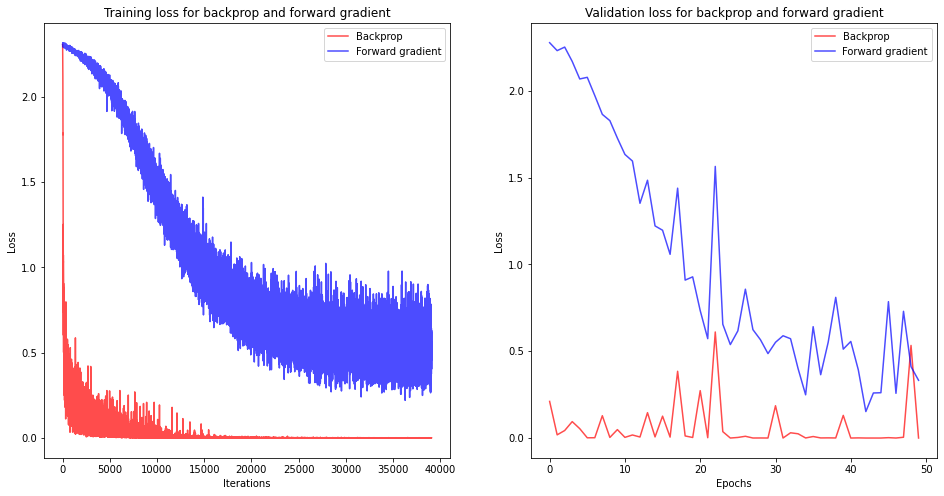

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Test loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-4, -3, 3)
momentums = np.linspace(0.1, 0.9, 4)

epochs = 20

for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=1e-6, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.5f')}, momentum = {format(momentum,'.3f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.00010, momentum = 0.100: 2.173
Validation loss for lr = 0.00010, momentum = 0.367: 2.035
Validation loss for lr = 0.00010, momentum = 0.633: 1.590
Validation loss for lr = 0.00010, momentum = 0.900: 1.303
Validation loss for lr = 0.00032, momentum = 0.100: 1.177
Validation loss for lr = 0.00032, momentum = 0.367: 0.771
Validation loss for lr = 0.00032, momentum = 0.633: 0.918
Validation loss for lr = 0.00032, momentum = 0.900: 8.816
Validation loss for lr = 0.00100, momentum = 0.100: 1.753
Validation loss for lr = 0.00100, momentum = 0.367: 4.272
Validation loss for lr = 0.00100, momentum = 0.633: 7.465
Validation loss for lr = 0.00100, momentum = 0.900: 11.404


Searching for best learning rate and momentum for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 4)
momentums = np.linspace(0.5, 0.9, 4)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net
    backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD

    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.4f')}, momentum = {format(momentum,'.3f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.0010, momentum = 0.500: 0.432
Validation loss for lr = 0.0010, momentum = 0.633: 0.367
Validation loss for lr = 0.0010, momentum = 0.767: 0.317
Validation loss for lr = 0.0010, momentum = 0.900: 0.230
Validation loss for lr = 0.0046, momentum = 0.500: 0.237
Validation loss for lr = 0.0046, momentum = 0.633: 0.201
Validation loss for lr = 0.0046, momentum = 0.767: 0.157
Validation loss for lr = 0.0046, momentum = 0.900: 0.088
Validation loss for lr = 0.0215, momentum = 0.500: 0.100
Validation loss for lr = 0.0215, momentum = 0.633: 0.085
Validation loss for lr = 0.0215, momentum = 0.767: 0.075
Validation loss for lr = 0.0215, momentum = 0.900: 0.070
Validation loss for lr = 0.1000, momentum = 0.500: 0.068
Validation loss for lr = 0.1000, momentum = 0.633: 0.077
Validation loss for lr = 0.1000, momentum = 0.767: 0.073
Validation loss for lr = 0.1000, momentum = 0.900: 0.114


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations above
lr = 0.00032
momentum = 0.367
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.276317596435547
Test loss in epoch 2: 2.2221546173095703
Test loss in epoch 3: 2.2201828956604004
Test loss in epoch 4: 2.124596357345581
Test loss in epoch 5: 2.0300662517547607
Test loss in epoch 6: 1.9918324947357178
Test loss in epoch 7: 1.8493239879608154
Test loss in epoch 8: 1.7068791389465332
Test loss in epoch 9: 1.6936469078063965
Test loss in epoch 10: 1.5462493896484375
Test loss in epoch 11: 1.4705729484558105
Test loss in epoch 12: 1.463754415512085
Test loss in epoch 13: 1.0785850286483765
Test loss in epoch 14: 1.4023302793502808
Test loss in epoch 15: 0.870995283126831
Test loss in epoch 16: 1.00474214553833
Test loss in epoch 17: 0.8807178139686584
Test loss in epoch 18: 1.2184250354766846
Test loss in epoch 19: 0.7201191782951355
Test loss in epoch 20: 0.8235723972320557
Test loss in epoch 21: 0.5875415802001953
Test loss in epoch 22: 0.3623698055744171
Test loss in epoch 23: 1.3015860319137573
Test loss in epoch 24: 0.5479764938354492
Test lo

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.1
momentum = 0.500
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net
backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.1315249800682068
Test loss in epoch 2: 0.027862874791026115
Test loss in epoch 3: 0.015424213372170925
Test loss in epoch 4: 0.07659266144037247
Test loss in epoch 5: 0.07654809951782227
Test loss in epoch 6: 0.001847417326644063
Test loss in epoch 7: 0.0005271852132864296
Test loss in epoch 8: 0.1853225827217102
Test loss in epoch 9: 0.00035277678398415446
Test loss in epoch 10: 0.03044058382511139
Test loss in epoch 11: 0.0014210273511707783
Test loss in epoch 12: 0.0026413039304316044
Test loss in epoch 13: 0.0003972149279434234
Test loss in epoch 14: 0.1844155192375183
Test loss in epoch 15: 0.02047288976609707
Test loss in epoch 16: 0.13774517178535461
Test loss in epoch 17: 0.0028007777873426676
Test loss in epoch 18: 0.4754335880279541
Test loss in epoch 19: 0.0006850249483250082
Test loss in epoch 20: 0.0031849120277911425
Test loss in epoch 21: 0.31692641973495483
Test loss in epoch 22: 0.00020110580953769386
Test loss in epoch 23: 0.5706037282943726
Te

#### Comparing results

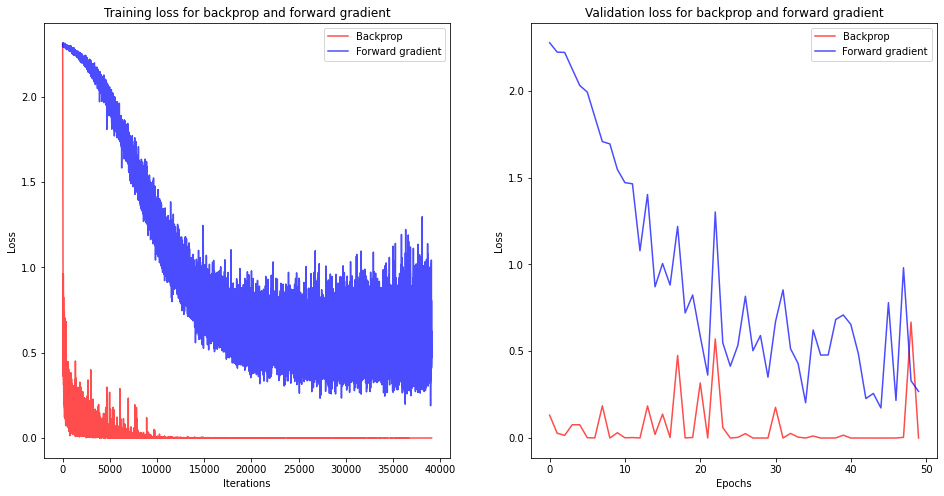

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## Adam 

#### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

##### Forward gradient

In the following section we tune the learning rate ($\gamma$), as well as the decay rate for the first ($\beta_1$) and second ($\beta_2$) moment. For the regular Adam algorithm implemented in Pytorch, it is recommended to use $(\beta_1, \beta_2) = (0.9, 0.999)$. As the forward gradient introduces more noise than the gradient from backpropagation, we choose to focus our search in values larger than the recommended ones. The intuition is that this can mitigate the noise introduced by the forward gradient by taking the exponential weighed average over more gradients. 

In [ ]:
torch.manual_seed(42)

# learning rate and decays search for forward gradient
learning_rates = [0.0001, 0.00025, 0.0005, 0.00075]
b1s = [0.9, 0.95, 0.99]
b2s = [0.999, 0.9995, 0.9999]

epochs = 10

for gamma in learning_rates:
  for b1 in b1s:
    for b2 in b2s:
      net = Net().to(device) # defining net

      # making the net functional to run the code in functorch
      # for evaluating the Jacobian-vector product
      func, params = ft.make_functional(net)

      # removing requires gradient as it will not be used
      # for the forward AD
      for param in params:
          param.requires_grad_(False)

      # defining our optimizer
      opt = ForwardAdam(func, functional_xent, params, lr=gamma, decay=0, betas=(b1, b2))
      for e in range(epochs):
        # training
        for i, (image, label) in enumerate(train_data_loader):
          image, label = image.to(device), label.to(device)
          params, loss = opt.step(image, label)
      # evaluating on the test set
      for i, (image, label) in enumerate(val_data_loader):
        batch_loss = []
        with torch.no_grad():
          image, label = image.to(device), label.to(device)
          val_loss = functional_xent(params, func,image, label)
          batch_loss.append(val_loss.item())
      print(f"Validation loss for lr = {gamma:.6f}, b1 = {b1}, b2 = {b2}: {np.mean(batch_loss)}")

Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.999: 2.166569948196411
Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.9995: 2.128404140472412
Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.9999: 2.181664228439331
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.999: 2.1515843868255615
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.9995: 2.1910202503204346
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.9999: 2.096067428588867
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.999: 2.146611213684082
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.9995: 2.1624722480773926
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.9999: 2.231780529022217
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.999: 1.8335461616516113
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.9995: 1.6036200523376465
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.9999: 1.5054351091384888
Validation loss for lr = 0.000250, b1 = 0.95, b2 = 0.999: 1.7413506507873535
Val

##### Standard backpropagation

We fix our decay rates to Pytorch's recommended values, i.e. $(\beta_1, \beta_2) = (0.9, 0.999)$, and tune the learning rate. In addition, we train train for more epochs than in the case of the forward gradient, as we found that training for 10 epochs wasn't representable for the performance of backpropagation training for 50 epochs.  

In [ ]:
torch.manual_seed(42)
# learning rate search
learning_rates = np.logspace(-4, -1, 4)
epochs = 30
for gamma in learning_rates:
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=gamma)

  for e in range(epochs):
    # training
    for i, (image, label) in enumerate(train_data_loader):
      image, label = image.to(device), label.to(device)
      optimizer.zero_grad()
      outputs = net(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()

  # evaluating on the test set
  for i, (image, label) in enumerate(val_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      outputs = net(image)
      val_loss = criterion(outputs, label)
      batch_loss.append(val_loss.item())
  print(f"Validation loss for lr = {gamma:.6f}: {np.mean(batch_loss)}")

Validation loss for lr = 0.000100: 0.003653669962659478
Validation loss for lr = 0.001000: 4.321323388012388e-07
Validation loss for lr = 0.010000: 0.010016413405537605
Validation loss for lr = 0.100000: 2.005514621734619


#### Forward gradient:

Train model with the best hyperparameters

In [ ]:
torch.manual_seed(42)

net = Net().to(device) # defining net

# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardAdam(func, functional_xent, params, lr=0.0005, decay=5e-5, betas=(0.99, 0.999))

epochs = 50

# storing losses
losses_fwd = []
test_losses_fwd = []
for e in range(epochs):
  # training
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {test_losses_fwd[-1]}")

Test loss in epoch 1: 2.19032883644104
Test loss in epoch 2: 2.0565240383148193
Test loss in epoch 3: 2.028681516647339
Test loss in epoch 4: 1.732128381729126
Test loss in epoch 5: 1.586273193359375
Test loss in epoch 6: 1.3238673210144043
Test loss in epoch 7: 1.141480565071106
Test loss in epoch 8: 1.0360242128372192
Test loss in epoch 9: 1.2310892343521118
Test loss in epoch 10: 1.0009692907333374
Test loss in epoch 11: 0.993780255317688
Test loss in epoch 12: 0.887806236743927
Test loss in epoch 13: 0.6930335164070129
Test loss in epoch 14: 1.128116488456726
Test loss in epoch 15: 0.6583871841430664
Test loss in epoch 16: 0.8870062232017517
Test loss in epoch 17: 0.6957871317863464
Test loss in epoch 18: 1.1672656536102295
Test loss in epoch 19: 0.6501531600952148
Test loss in epoch 20: 0.5636391639709473
Test loss in epoch 21: 0.4535113573074341
Test loss in epoch 22: 0.4720851182937622
Test loss in epoch 23: 1.2993414402008057
Test loss in epoch 24: 0.4338979125022888
Test loss 

#### Standard backpropagation:

Although the hyperaparameter search above yielded an ideal learning rate of 0.001, this resulted in significant oscillations when running for 50 epochs. We therefore tried the recommended value for the learning rate ($\gamma = 0.0001$), and found that it worked much better. This is what we have used. 

Train model with the best hyperparameters. We also add a regularization term (weight_decay), as we found that this reduced oscillations in later epochs. 

In [ ]:
torch.manual_seed(42)

epochs = 50
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net
backprop = torch.optim.Adam(net.parameters(), lr=0.0001)

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    # Compute loss and gradient
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    # Update parameters
    backprop.step()
    # Save loss
    losses.append(loss.item())
  for i, (image, label) in enumerate(test_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.3100331425666809
Test loss in epoch 2: 0.0140520129352808
Test loss in epoch 3: 0.14556804299354553
Test loss in epoch 4: 0.15339039266109467
Test loss in epoch 5: 0.1583276093006134
Test loss in epoch 6: 0.002723414683714509
Test loss in epoch 7: 0.0010249821934849024
Test loss in epoch 8: 0.03242543339729309
Test loss in epoch 9: 0.009752126410603523
Test loss in epoch 10: 0.04520244896411896
Test loss in epoch 11: 0.015624778345227242
Test loss in epoch 12: 0.003691958962008357
Test loss in epoch 13: 0.0019303475273773074
Test loss in epoch 14: 0.20341354608535767
Test loss in epoch 15: 0.00106672418769449
Test loss in epoch 16: 0.2685122489929199
Test loss in epoch 17: 0.012949435971677303
Test loss in epoch 18: 0.46612802147865295
Test loss in epoch 19: 0.011894124560058117
Test loss in epoch 20: 0.0004868134274147451
Test loss in epoch 21: 0.10420506447553635
Test loss in epoch 22: 2.251319347124081e-05
Test loss in epoch 23: 0.2851734459400177
Test loss i

### Comparing results

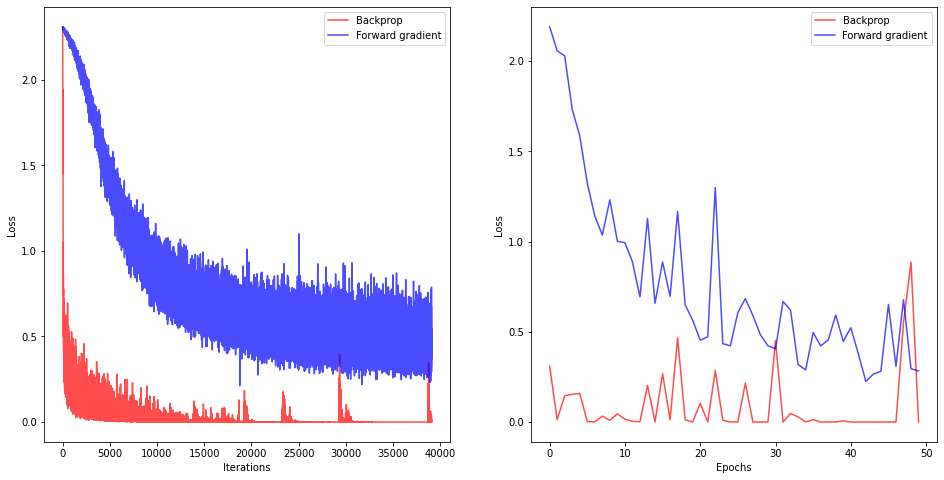

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].legend()

# Convolutional Neural Network

We then use a CNN. Code can be found in `models.py`.

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
decays = [1e-5, 1e-6]

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000010: 2.303
Validation loss for lr = 0.000010, decay = 0.000001: 2.302
Validation loss for lr = 0.000025, decay = 0.000010: 2.302
Validation loss for lr = 0.000025, decay = 0.000001: 2.304
Validation loss for lr = 0.000063, decay = 0.000010: 2.301
Validation loss for lr = 0.000063, decay = 0.000001: 2.302
Validation loss for lr = 0.000158, decay = 0.000010: 2.301
Validation loss for lr = 0.000158, decay = 0.000001: 2.299
Validation loss for lr = 0.000398, decay = 0.000010: 2.275
Validation loss for lr = 0.000398, decay = 0.000001: 2.284
Validation loss for lr = 0.001000, decay = 0.000010: 14.432
Validation loss for lr = 0.001000, decay = 0.000001: 14.368


Searching for best learning rate and learning rate decay for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 6)
decays = [0]

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = ConvNet().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.001000, decay = 0.000000: 0.447
Validation loss for lr = 0.002512, decay = 0.000000: 0.199
Validation loss for lr = 0.006310, decay = 0.000000: 0.060
Validation loss for lr = 0.015849, decay = 0.000000: 0.049
Validation loss for lr = 0.039811, decay = 0.000000: 0.091
Validation loss for lr = 0.100000, decay = 0.000000: 0.041


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.296
Test loss in epoch 2: 2.298
Test loss in epoch 3: 2.298
Test loss in epoch 4: 2.298
Test loss in epoch 5: 2.299
Test loss in epoch 6: 2.296
Test loss in epoch 7: 2.294
Test loss in epoch 8: 2.290
Test loss in epoch 9: 2.297
Test loss in epoch 10: 2.299
Test loss in epoch 11: 2.291
Test loss in epoch 12: 2.289
Test loss in epoch 13: 2.273
Test loss in epoch 14: 2.262
Test loss in epoch 15: 2.251
Test loss in epoch 16: 2.196
Test loss in epoch 17: 2.184
Test loss in epoch 18: 2.132
Test loss in epoch 19: 2.043
Test loss in epoch 20: 1.838
Test loss in epoch 21: 1.700
Test loss in epoch 22: 1.619
Test loss in epoch 23: 1.237
Test loss in epoch 24: 1.109
Test loss in epoch 25: 1.153
Test loss in epoch 26: 0.922
Test loss in epoch 27: 0.729
Test loss in epoch 28: 0.846
Test loss in epoch 29: 0.675
Test loss in epoch 30: 0.783
Test loss in epoch 31: 0.747
Test loss in epoch 32: 0.655
Test loss in epoch 33: 0.787
Test loss in epoch 34: 0.661
Test loss in epoch 35: 

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.1
decay = 0
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.011456367559731007
Test loss in epoch 2: 0.000898439553566277
Test loss in epoch 3: 0.08411397784948349
Test loss in epoch 4: 0.07168854027986526
Test loss in epoch 5: 0.0018400436965748668
Test loss in epoch 6: 0.00031653069891035557
Test loss in epoch 7: 0.0018646365497261286
Test loss in epoch 8: 3.0781575333094224e-05
Test loss in epoch 9: 0.0026352398563176394
Test loss in epoch 10: 1.7440714145777747e-05
Test loss in epoch 11: 0.057991791516542435
Test loss in epoch 12: 1.3655467228090856e-05
Test loss in epoch 13: 1.4901159417490817e-08
Test loss in epoch 14: 9.102375770453364e-05
Test loss in epoch 15: 9.39462915994227e-06
Test loss in epoch 16: 3.9487952108174795e-07
Test loss in epoch 17: 4.650418122764677e-05
Test loss in epoch 18: 0.00023462824174202979
Test loss in epoch 19: 0.009191622026264668
Test loss in epoch 20: 9.23866139146412e-07
Test loss in epoch 21: 6.857820699224249e-05
Test loss in epoch 22: 2.7864550702361157e-06
Test loss in epoch 23

#### Comparing results

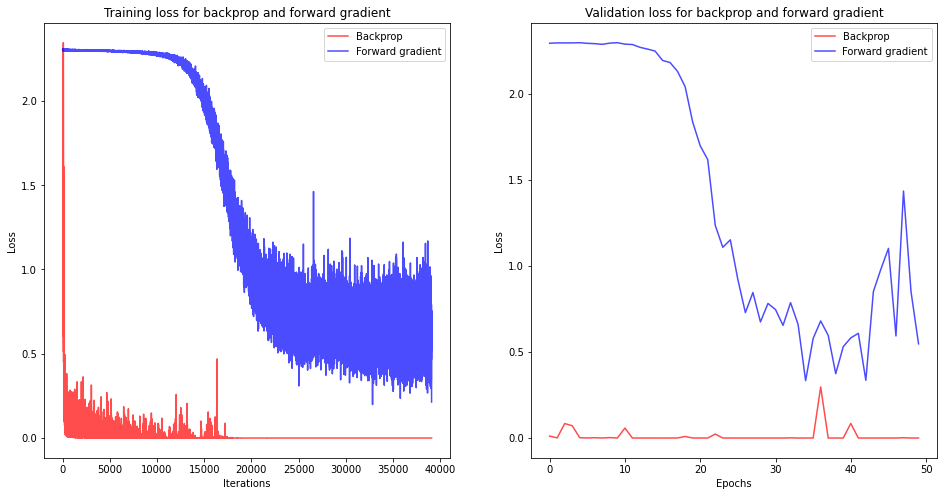

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-5, -3, 3)
momentums = np.linspace(0.3, 0.9, 3)

epochs = 20

for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=1e-4, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, Momentum = 0.300000: 2.303
Validation loss for lr = 0.000010, Momentum = 0.600000: 2.303
Validation loss for lr = 0.000010, Momentum = 0.900000: 2.302
Validation loss for lr = 0.000100, Momentum = 0.300000: 2.300
Validation loss for lr = 0.000100, Momentum = 0.600000: 2.297
Validation loss for lr = 0.000100, Momentum = 0.900000: 0.914
Validation loss for lr = 0.001000, Momentum = 0.300000: 0.647
Validation loss for lr = 0.001000, Momentum = 0.600000: 4.427
Validation loss for lr = 0.001000, Momentum = 0.900000: 12.893


Searching for best learning rate and momentum for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-2, -1, 3)
momentums = np.linspace(0.7, 0.95, 4)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net
    backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD
    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.010000, Momentum = 0.700000: 0.065
Validation loss for lr = 0.010000, Momentum = 0.783333: 0.038
Validation loss for lr = 0.010000, Momentum = 0.866667: 0.039
Validation loss for lr = 0.010000, Momentum = 0.950000: 0.067
Validation loss for lr = 0.031623, Momentum = 0.700000: 0.047
Validation loss for lr = 0.031623, Momentum = 0.783333: 0.044
Validation loss for lr = 0.031623, Momentum = 0.866667: 0.040
Validation loss for lr = 0.031623, Momentum = 0.950000: 0.067
Validation loss for lr = 0.100000, Momentum = 0.700000: 0.039
Validation loss for lr = 0.100000, Momentum = 0.783333: 0.033
Validation loss for lr = 0.100000, Momentum = 0.866667: 2.305
Validation loss for lr = 0.100000, Momentum = 0.950000: 2.309


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
# the one giving best value was found to be unstable
# so we chose the best with 1e-4 in learning rate
lr = 0.000100
momentum = 0.900
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, decay=1e-4, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.293980121612549
Test loss in epoch 2: 2.2952094078063965
Test loss in epoch 3: 2.304154396057129
Test loss in epoch 4: 2.290764093399048
Test loss in epoch 5: 2.2867608070373535
Test loss in epoch 6: 2.2619686126708984
Test loss in epoch 7: 2.2372543811798096
Test loss in epoch 8: 2.2206125259399414
Test loss in epoch 9: 2.1331124305725098
Test loss in epoch 10: 1.9237395524978638
Test loss in epoch 11: 1.7503767013549805
Test loss in epoch 12: 1.434783697128296
Test loss in epoch 13: 1.151145339012146
Test loss in epoch 14: 1.1734180450439453
Test loss in epoch 15: 0.9243830442428589
Test loss in epoch 16: 0.4465095102787018
Test loss in epoch 17: 0.9454644918441772
Test loss in epoch 18: 0.8502824306488037
Test loss in epoch 19: 0.7681668400764465
Test loss in epoch 20: 0.4545000195503235
Test loss in epoch 21: 0.6109587550163269
Test loss in epoch 22: 1.0090630054473877
Test loss in epoch 23: 0.5103486180305481
Test loss in epoch 24: 0.3720456659793854
Test l

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
momentum = 0.783
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net
backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.013984394259750843
Test loss in epoch 2: 0.002277267863973975
Test loss in epoch 3: 0.009719198569655418
Test loss in epoch 4: 0.0057722171768546104
Test loss in epoch 5: 0.010010404512286186
Test loss in epoch 6: 0.00035383200156502426
Test loss in epoch 7: 0.02034526690840721
Test loss in epoch 8: 0.001686809933744371
Test loss in epoch 9: 0.001692623132839799
Test loss in epoch 10: 0.0010761108715087175
Test loss in epoch 11: 0.024556422606110573
Test loss in epoch 12: 4.917242222290952e-06
Test loss in epoch 13: 7.525058549617825e-07
Test loss in epoch 14: 0.0002828693832270801
Test loss in epoch 15: 0.00028416060376912355
Test loss in epoch 16: 2.0935788143106038e-06
Test loss in epoch 17: 0.00012849144695792347
Test loss in epoch 18: 5.3412120905704796e-05
Test loss in epoch 19: 0.22871695458889008
Test loss in epoch 20: 7.078015755723754e-07
Test loss in epoch 21: 9.074167792277876e-06
Test loss in epoch 22: 6.474384008470224e-06
Test loss in epoch 23: 0.

#### Comparing results

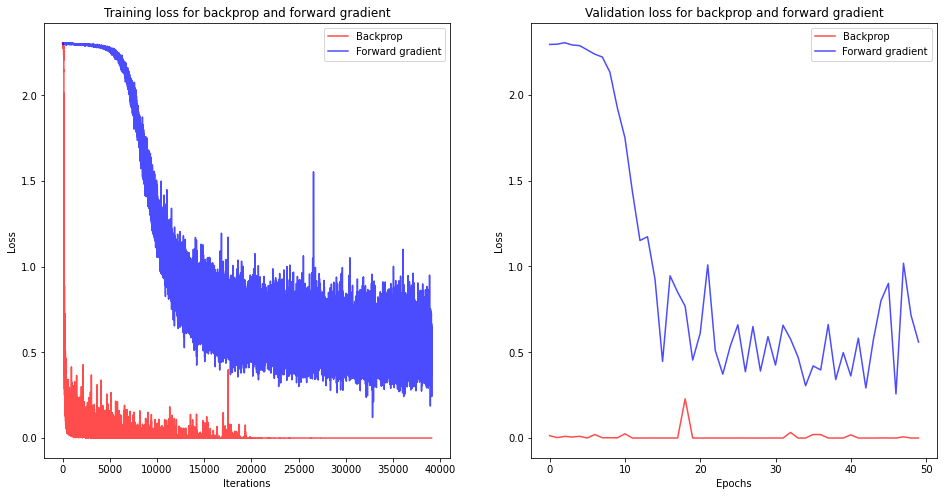

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## Adam

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

##### Forward gradient:

Similar to tuning the Dense Neural Network with forward gradients, we search for larger decay rates, and the same learning rates.

In [ ]:
torch.manual_seed(42)

# learning rate and decays search for forward gradient

learning_rates = [0.0001, 0.00025, 0.0005, 0.00075]
b1s = [0.9, 0.95, 0.99]
b2s = [0.999, 0.9995, 0.9999]

EPOCHS = 10

for gamma in learning_rates:
  for b1 in b1s:
    for b2 in b2s:
      net = ConvNet().to(device) # defining net

      # making the net functional to run the code in functorch
      # for evaluating the Jacobian-vector product
      func, params = ft.make_functional(net)

      # removing requires gradient as it will not be used
      # for the forward AD
      for param in params:
          param.requires_grad_(False)

      # defining our optimizer
      opt = ForwardAdam(func, functional_xent, params, lr=gamma, decay=0, betas=(b1, b2))
      # running the code for e epochs
      for e in range(EPOCHS):
        # training
        for i, (image, label) in enumerate(train_data_loader):
          image, label = image.to(device), label.to(device)
          params, loss = opt.step(image, label)
        # evaluating on the test set
      for i, (image, label) in enumerate(val_data_loader):
        batch_loss = []
        with torch.no_grad():
          image, label = image.to(device), label.to(device)
          val_loss = functional_xent(params, func,image, label)
          batch_loss.append(val_loss.item())
      print(f"Validation loss for lr = {gamma:.6f}, b1 = {b1}, b2 = {b2}: {np.mean(batch_loss)}")

Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.999: 2.2818660736083984
Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.9995: 2.268524169921875
Validation loss for lr = 0.000100, b1 = 0.9, b2 = 0.9999: 2.2883944511413574
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.999: 2.290336847305298
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.9995: 2.237319231033325
Validation loss for lr = 0.000100, b1 = 0.95, b2 = 0.9999: 2.276641845703125
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.999: 2.2715959548950195
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.9995: 2.2723121643066406
Validation loss for lr = 0.000100, b1 = 0.99, b2 = 0.9999: 2.2055413722991943
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.999: 1.1547170877456665
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.9995: 1.091759204864502
Validation loss for lr = 0.000250, b1 = 0.9, b2 = 0.9999: 0.6090658903121948
Validation loss for lr = 0.000250, b1 = 0.95, b2 = 0.999: 1.069260835647583
Val

##### Standard backpropagation:

Similar to tuning the Dense Neural Network with backpropagation, we only tune the learning rate. 

In [ ]:
torch.manual_seed(42)

learning_rates = 10**np.random.uniform(-5, -2, 7)
epochs = 20
for gamma in learning_rates:
  net = ConvNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=gamma)

  for e in range(epochs):
    # training

    for i, (image, label) in enumerate(train_data_loader):
      image, label = image.to(device), label.to(device)
      optimizer.zero_grad()
      outputs = net(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()

  # evaluating on the test set
  for i, (image, label) in enumerate(val_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      outputs = net(image)
      val_loss = criterion(outputs, label)
      batch_loss.append(val_loss.item())
  print(f"Validation loss for lr = {gamma:.6f}: {np.mean(batch_loss)}")

Validation loss for lr = 0.000058: 0.0001399812026647851
Validation loss for lr = 0.000093: 0.3475811183452606
Validation loss for lr = 0.002688: 0.22255480289459229
Validation loss for lr = 0.003776: 0.1247880607843399
Validation loss for lr = 0.000236: 1.7136326846411976e-07
Validation loss for lr = 0.000057: 0.0052656205371022224
Validation loss for lr = 0.000033: 0.0015127189690247178


#### Forward gradient

Train and test with best found hyperparameters

In [ ]:
torch.manual_seed(42)

net = ConvNet().to(device) # defining net

# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardAdam(func, functional_xent, params, lr=0.00025, decay=1e-4, betas=(0.9, 0.9999))

# running the code for e epochs
losses_fwd = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  # training
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {test_losses_fwd[-1]}")

Test loss in epoch 1: 2.293194532394409
Test loss in epoch 2: 2.2932040691375732
Test loss in epoch 3: 2.2868504524230957
Test loss in epoch 4: 2.261190891265869
Test loss in epoch 5: 2.2527005672454834
Test loss in epoch 6: 2.1274216175079346
Test loss in epoch 7: 2.055299758911133
Test loss in epoch 8: 2.0111982822418213
Test loss in epoch 9: 1.66861093044281
Test loss in epoch 10: 1.5598170757293701
Test loss in epoch 11: 1.496523380279541
Test loss in epoch 12: 1.1717092990875244
Test loss in epoch 13: 1.0109148025512695
Test loss in epoch 14: 1.1480114459991455
Test loss in epoch 15: 0.9627612829208374
Test loss in epoch 16: 0.4285634160041809
Test loss in epoch 17: 0.8723673820495605
Test loss in epoch 18: 0.965835690498352
Test loss in epoch 19: 0.8006963133811951
Test loss in epoch 20: 0.5275888442993164
Test loss in epoch 21: 0.783503532409668
Test loss in epoch 22: 1.0791494846343994
Test loss in epoch 23: 0.6083266735076904
Test loss in epoch 24: 0.5362035632133484
Test loss

#### Standard backpropagation

Train and test with best found hyperparameters

In [ ]:
torch.manual_seed(42)

criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net
backprop = torch.optim.Adam(net.parameters(), lr=0.000236)

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  for i, (image, label) in enumerate(test_data_loader):
    batch_loss = []
    with torch.no_grad():
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.021297501400113106
Test loss in epoch 2: 0.001154738711193204
Test loss in epoch 3: 0.05136535316705704
Test loss in epoch 4: 0.0028678965754806995
Test loss in epoch 5: 0.000884181063156575
Test loss in epoch 6: 0.05570447817444801
Test loss in epoch 7: 0.002024772111326456
Test loss in epoch 8: 0.0001084710456780158
Test loss in epoch 9: 0.017877774313092232
Test loss in epoch 10: 0.0012856440152972937
Test loss in epoch 11: 0.0038263462483882904
Test loss in epoch 12: 7.078035650920356e-07
Test loss in epoch 13: 1.0952263664876227e-06
Test loss in epoch 14: 0.000181771902134642
Test loss in epoch 15: 0.0004960029036737978
Test loss in epoch 16: 6.705521116145974e-08
Test loss in epoch 17: 6.019932243361836e-06
Test loss in epoch 18: 5.228299414739013e-05
Test loss in epoch 19: 0.0012971418909728527
Test loss in epoch 20: 8.426107342529576e-06
Test loss in epoch 21: 0.02471250668168068
Test loss in epoch 22: 1.5711710148025304e-05
Test loss in epoch 23: 0.0003

### Comparing results

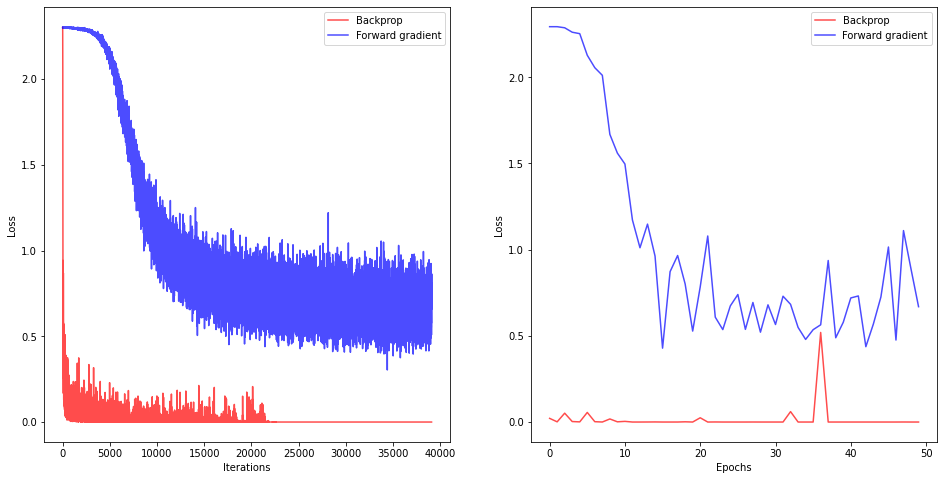

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].legend()